# Calculating Document Similarity with Named Entity Recognition, TF-IDF, and Cosine Similarity

by <br>
Albert Edwillian Pratomo     / 26415175 <br>
Martina Marcelline / 26415031

### Libraries used

In this little project, we used [Natural Language Toolkit (NLTK) 3.3.](https://www.nltk.org/), [Pandas](https://pandas.pydata.org/), and [NumPy](http://www.numpy.org/).

Installing the packages with pip in the command line environment won't let Jupyter read the packages, so we have to install via sys.executable as demonstrated in the cell below. Reference: [Installing Python Packages from a Jupyter Notebook](http://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/)

In [1]:
#  import sys
#  !{sys.executable} -m pip install nltk
#  !{sys.executable} -m pip install numpy
#  !{sys.executable} -m pip install pandas

#uncomment the above if the packages aren't installed yet

In [2]:
import math
import string
import pandas as pd
import numpy as np
from nltk import pos_tag, ne_chunk
from nltk.tree import Tree
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

## 0. Initialization

We initialize by defining stop words (in this case, English [stop words](https://en.wikipedia.org/wiki/Stop_words)), making global variables and adjusting the [pandas dataframes' settings](https://pandas.pydata.org/pandas-docs/stable/options.html) for better viewing:

In [3]:
# Global variables
stop_words = set(stopwords.words('english'))
documents = []
tokens = []
index1=[]

ps = PorterStemmer()

#Tweak dataframes
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)

Then, we define the functions which we will use later:

In [4]:
def readFile(pathFile):
    f = open(pathFile)
    s = f.read()
    return s

# Preprocessing functions
def nerTokenize(text):
	tokens = []
	for sentence in sent_tokenize(text):
		# Create named entity chunk tree
		chunks = ne_chunk(pos_tag(word_tokenize(sentence)))
		for elt in chunks:
			if isinstance(elt, Tree):
				s = ""
				for e in elt:
					s = s + e[0] + " "
				# Remove space at the end
				s = s[:-1] 
				tokens.append(s)
			else:
				tokens.append(elt[0])
	return tokens
def removeStopWords(tokens):
	for t in tokens:
		for w in t:
			if w in stop_words:
				t.remove(w)
	return tokens

def stemTokens(tokens):
	for t in tokens:
		for i in range(len(t)):
			t[i] = ps.stem(t[i])
	return tokens

# TF-IDF functions
def computeTF(wordDict, bow):
    tfDict = {}
    bowCount = len(bow)
    for word, count in wordDict.items():
        tfDict[word] = count/float(bowCount)
    return tfDict

def computeIDF(docList):
    import math
    idfDict = {}
    N = len(docList)
    
    idfDict = dict.fromkeys(docList[0].keys(), 0)
    for doc in docList:
        for word, val in doc.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log10(1+(N / float(val)))
        
    return idfDict

def computeTFIDF(tfBow, idfs):
    tfidf = {}
    for word, val in tfBow.items():
        tfidf[word] = val*idfs[word]
    return tfidf

def v_norm(a):
    return math.sqrt(np.dot(a, a))

def computeCosSim(vector1, vector2):
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)
    return np.dot(vector1, vector2) / (v_norm(vector1) * v_norm(vector2))

### Reading the input files

We read our input files, convert them to string, and remove punctuation and digits for easy tokenizing.

In [5]:
# Translation to remove punctuation and digits
punct = str.maketrans('', '', string.punctuation)
digitst = str.maketrans('', '', string.digits)

# Read each document and append them all
numDocs = input("How many documents are we working with? ")
for i in range(0,int(numDocs)):
    docName = input("File name of document "+str(i+1)+": ")
    raw = readFile(str(docName))
    raw = raw.translate(punct)
#     raw = raw.translate(digitst)
    documents.append(raw)
    index1.append(docName)

df0 = pd.DataFrame(documents,index=index1)
df0.columns=['Full text without punctuation and digits']
df0

How many documents are we working with? 3
File name of document 1: coba.txt
File name of document 2: coba2.txt
File name of document 3: coba3.txt


,Full text without punctuation and digits
coba.txt,I was born in New York I am a second child
coba2.txt,My child has a new toy He broke it in seconds
coba3.txt,This is my second time in New York


## 1. [Tokenizing](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) our documents

1. We tokenize our texts along with [**Named Entity Recognition**](https://en.wikipedia.org/wiki/Named-entity_recognition), in which we extract multi-word named entities such as "Los Angeles" as one token instead of two for better comparison accuracy.

In [6]:
#1. Tokenize each document
for d in documents:
    tokens.append(nerTokenize(d))
# Visualize using dataframe
dft = pd.DataFrame(tokens,index=index1)
dft

,0,1,2,3,4,5,6,7,8,9,10
coba.txt,I,was,born,in,New York,I,am,a,second,child,None
coba2.txt,My,child,has,a,new,toy,He,broke,it,in,seconds
coba3.txt,This,is,my,second,time,in,New York,None,None,None,None


<br>

2. Then, we **remove stop words** using the list of stop words we defined earlier.

In [7]:
#2. Remove stop words
tokens = removeStopWords(tokens)
# Visualize using dataframe
dft = pd.DataFrame(tokens,index=index1)
dft

,0,1,2,3,4,5,6,7,8
coba.txt,I,born,New York,I,a,second,child,None,None
coba2.txt,My,child,a,new,toy,He,broke,in,seconds
coba3.txt,This,my,second,time,New York,None,None,None,None


<br>
3. After removing stop words, we **stem** the tokens, in which we reduce derived or inflected words back to their "word stem"

In [8]:
#3. Stem the tokens
tokens = stemTokens(tokens)
# Visualize using dataframe
dft = pd.DataFrame(tokens,index=index1)
dft

,0,1,2,3,4,5,6,7,8
coba.txt,I,born,new york,I,a,second,child,None,None
coba2.txt,My,child,a,new,toy,He,broke,in,second
coba3.txt,thi,my,second,time,new york,None,None,None,None


<br>
4. In our final step of tokenizing, we extract **distinct words** to omit duplicates from our data.

In [9]:
#4. Extract distinct words
distincts = set().union(*tokens)

#Populate dictionaries with tokens & counts
dicts = []
for i in range(len(tokens)):
    dicts.append(0)
    dicts[i] = dict.fromkeys(distincts, 0)
    for w in tokens[i]:
        dicts[i][w]+=1
#     names = list(dicts[i].keys())
#     values = list(dicts[i].values())
#     plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
#     plt.bar(range(len(dicts[i])),values,tick_label=names)
#     plt.show()

# Visualize using dataframe
df1 = pd.DataFrame.from_dict(dicts)
df1

,He,I,My,a,born,broke,child,in,my,new,new york,second,thi,time,toy
0,0,2,0,1,1,0,1,0,0,0,1,1,0,0,0
1,1,0,1,1,0,1,1,1,0,1,0,1,0,0,1
2,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0


The result is a list of unique, stemmed tokens without stop words and how often they appear in each document. 

## 2. Calculating [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (Term Frequency–Inverse Document Frequency) 

<img src="https://camo.githubusercontent.com/8b5a285d3a9736964d25e1cdd569a0d6374c80c1/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f3830302f312a3858706273523448644148425879354d6770497975672e706e67" align="left" width="450">

### Calculating TF (Term Frequency) 

In order to obtain the TF-IDF values of our tokens, we calculate **TF (Term Frequency)** first, in which we normalize the "raw" frequencies of the tokens (by dividing them by the frequency of the most common term in the document):

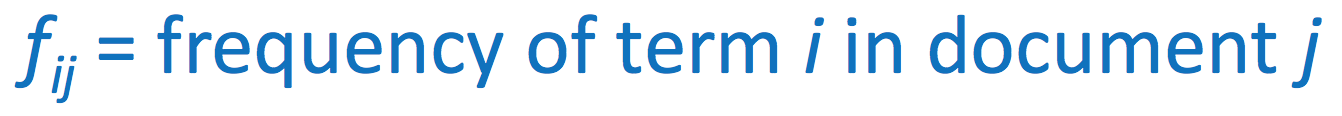 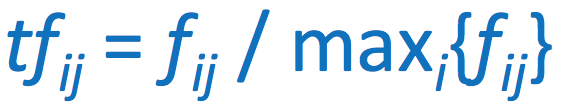 

In [10]:
#Calculate TF with function computeTF
tfResults = []
for i in range(len(tokens)):
    tfResults.append(0)
    tfResults[i] = computeTF(dicts[i],tokens[i])
#     print(tfResults[i])
df2 = pd.DataFrame(tfResults,index=index1)
df2

,He,I,My,a,born,broke,child,in,my,new,new york,second,thi,time,toy
coba.txt,0.000000,0.285714,0.000000,0.142857,0.142857,0.000000,0.142857,0.000000,0.0,0.000000,0.142857,0.142857,0.0,0.0,0.000000
coba2.txt,0.111111,0.000000,0.111111,0.111111,0.000000,0.111111,0.111111,0.111111,0.0,0.111111,0.000000,0.111111,0.0,0.0,0.111111
coba3.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.200000,0.200000,0.2,0.2,0.000000


In the table above, we can see that **the more a term appears**, the **greater** the **TF** value.

### Calculating IDF (Inverse Document Frequency)

While TF measures how often a token appears in the documents, [**IDF (Inverse Document Frequency)**](https://moz.com/blog/inverse-document-frequency-and-the-importance-of-uniqueness) measures the **"rareness"** of a token within the documents. We need IDF because terms that appear in many different documents are **less indicative** of overall topic.

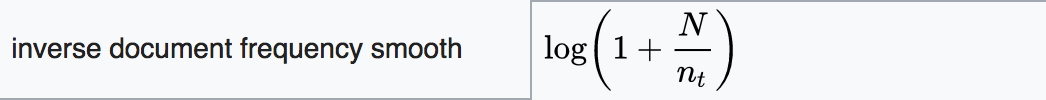

In [11]:
# Calculate IDF with function computeIDF 
idfResults = computeIDF(dicts)
df3 = pd.DataFrame(idfResults,index=[0])
# df3 = pd.DataFrame([])
# for i in range(len(idfResults)):
#     df3 = df3.append(pd.DataFrame(idfResults,index=[i]))
df3

,in,I,born,He,broke,thi,toy,time,child,new,my,second,My,new york,a
0,0.60206,0.60206,0.60206,0.60206,0.60206,0.60206,0.60206,0.60206,0.39794,0.60206,0.60206,0.30103,0.60206,0.39794,0.39794


Contrary to TF, we can see that **the more a term appears** in the documents, the **smaller** the **IDF** value.

### Calculating the TF-IDF value

In order to calculate our TF-IDF values, all we need to do is to **multiply TF by IDF**:

In [12]:
# Calculate TF-IDF with function computeTFIDF
tfidfResults = []
for i in range(len(tokens)):
    tfidfResults.append(0)
    tfidfResults[i] = computeTFIDF(tfResults[i],idfResults)
df4 = pd.DataFrame(tfidfResults,index=index1)
df4

,He,I,My,a,born,broke,child,in,my,new,new york,second,thi,time,toy
coba.txt,0.000000,0.172017,0.000000,0.056849,0.086009,0.000000,0.056849,0.000000,0.000000,0.000000,0.056849,0.043004,0.000000,0.000000,0.000000
coba2.txt,0.066896,0.000000,0.066896,0.044216,0.000000,0.066896,0.044216,0.066896,0.000000,0.066896,0.000000,0.033448,0.000000,0.000000,0.066896
coba3.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120412,0.000000,0.079588,0.060206,0.120412,0.120412,0.000000


In the same vein as IDF, **the more a term appears in the documents**, the less informative it is, therefore the **TF-IDF** value is **smaller** than terms which appear rarely.

## 3. Calculating [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity)

**Cosine similarity** measures the cosine of the angle between two vectors to calculate the degree of similarity between two vectors. In the context of calculating document similarity, our vectors are each and every one of our documents.

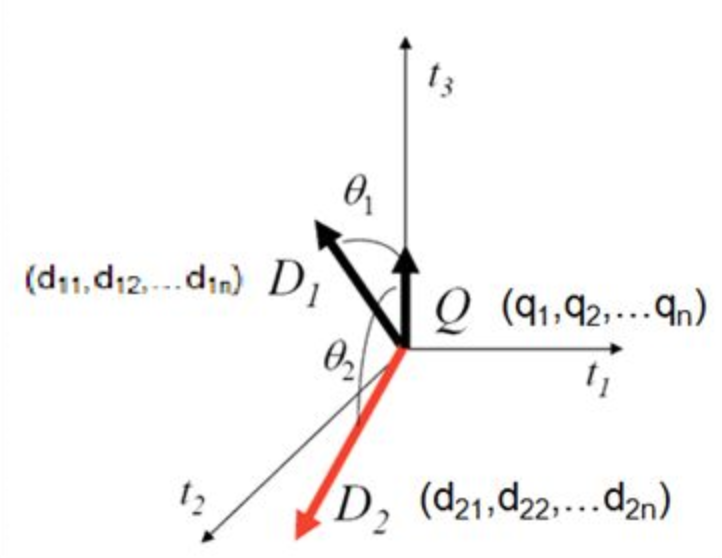
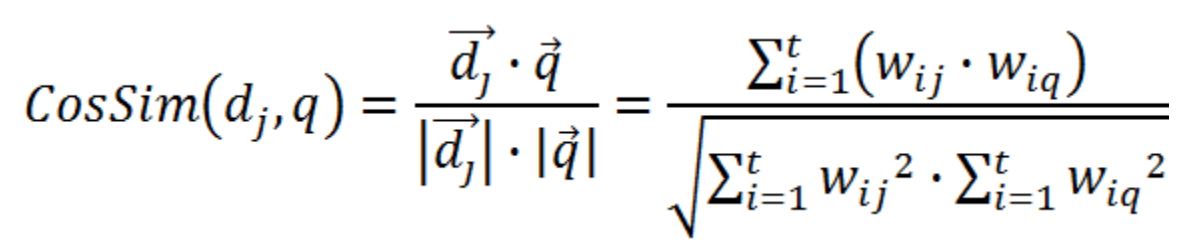

In [13]:
# extract TF-IDF values
vtfidf=[]
for i in range(len(documents)):
    vtfidf.append([x for x in tfidfResults[i].values()])

similarities=[]
index5=[]

# Calculate cosine similarity with function computeCosSim
for i in range(len(documents)):
    for j in range(len(documents)):
        if(i!=j):
            index5.append(index1[i]+" and "+index1[j])
            similarities.append(computeCosSim(vtfidf[i],vtfidf[j]))
df5 = pd.DataFrame(similarities,index = index5)
df5.columns=["Cosine Similarity"]
df5

,Cosine Similarity
coba.txt and coba2.txt,0.164377
coba.txt and coba3.txt,0.139661
coba2.txt and coba.txt,0.164377
coba2.txt and coba3.txt,0.048782
coba3.txt and coba.txt,0.139661
coba3.txt and coba2.txt,0.048782


Cosine similarity results range **from 0.0 to 1.0**, where **0.0** represents **no similarities whatsoever** between the documents and **1.0** means the two documents being compared are **the exact same**.

## References ##

* https://en.wikipedia.org/wiki/Named-entity_recognition
* <https://moz.com/blog/inverse-document-frequency-and-the-importance-of-uniqueness>
* <https://github.com/mayank408/TFIDF>